In [6]:
import pennylane as qml
from pennylane import numpy as np
import pandas as pd
import jax
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as mse
from scipy.optimize import minimize
from IPython.display import clear_output
import random 
from pennylane.optimize import AdamOptimizer,QNSPSAOptimizer
from utils import *
import os

from autoencoder3 import Autoencoder_composite

In [50]:
# Function to compute the reduced density matrix for specified qubits
def reduced_density_matrix(rho, target_qubits, total_qubits):
    """Compute the reduced density matrix for specified target_qubits
    by tracing out the other qubits in a mixed state.
    
    Args:
        rho (np.ndarray): The mixed state density matrix.
        target_qubits (list): List of qubits to keep in the reduced density matrix.
        total_qubits (int): Total number of qubits in the system.
        
    Returns:
        np.ndarray: The reduced density matrix for the target qubits.
    """
    # Determine which qubits to trace out
    trace_out_qubits = sorted(set(range(total_qubits)) - set(target_qubits))
    
    # Start with the original density matrix
    new_density_matrix = rho

    # Iteratively trace out each qubit in trace_out_qubits
    for qubit in trace_out_qubits:
        # Calculate the new dimension after tracing out one qubit
        dim = 2 ** (total_qubits - 1)  # Dimension after tracing out one qubit
        shape = new_density_matrix.shape
        
        # Create a new density matrix for the remaining subsystem
        reduced_dim = int(new_density_matrix.shape[0] / 2)
        new_density_matrix = np.zeros((reduced_dim, reduced_dim), dtype=complex)
        
        # Loop over the basis states of the qubit to be traced out
        for i in range(2):  # Loop for |0> and |1>
            # Calculate the indices to trace out
            indices = [j for j in range(shape[0]) if (j >> qubit) & 1 == i]
            # Extract the relevant block and sum it into the new density matrix
            new_density_matrix += new_density_matrix[np.ix_(indices, indices)]

        # Update the density matrix after tracing out the qubit
        rho = new_density_matrix

    # Return the reduced density matrix for the target qubits
    return new_density_matrix
def get_state_ae_ising(n_qb_input,ae):
    @qml.qnode(qml.device('default.mixed', wires=n_qb_input, shots=1000))
    def pio(a):
        dm1 = np.matmul( np.matrix(np.conjugate(a)).T, np.matrix(a) )
        qml.QubitDensityMatrix(dm1, wires=range(n_qb_input))
        ae.get_cirq(0)
        return qml.state()
    return pio


def compare_matrix_fidelity_ising(n_qubit_autoencoder,n_trash_qubit,ae,loc=9,interval = 1):
    data=get_data(n_qubit_autoencoder)
    
    m1=[]
    for b in range(1,100,interval):
        c1=[]
        for a in range(1,100,interval):
            res1 = get_state_ae_ising(n_qubit_autoencoder,ae)([data.ground_states[a]])
            print( list(range(n_qubit_autoencoder-1, n_trash_qubit-1,-1)))
            res1 = reduced_density_matrix(res1, list(range(n_qubit_autoencoder-1, n_trash_qubit-1,-1)), n_qubit_autoencoder)
            
            res2 = get_state_ae_ising(n_qubit_autoencoder,ae)([data.ground_states[b]])
            res1 = reduced_density_matrix(res1, list(range(n_qubit_autoencoder-1, n_trash_qubit-1,-1)), n_qubit_autoencoder)

            c1.append(qml.math.fidelity(res1, res2))
        m1.append(c1)
    orig=np.array([[np.abs( np.dot(data.ground_states[i], np.conjugate(data.ground_states[j])))**2 for j in range(1,100,interval)] for i in range(1,100,interval)])
    k=np.array(m1)-orig

    plt.figure(figsize=(20,5))
    ax=plt.subplot(1,3,1)
    sns.heatmap(np.array(m1),ax=ax)
    ax.set_title('Reduced')
    plt.xlabel("p")
    plt.ylabel("p")
    ax=plt.subplot(1,3,2)
    sns.heatmap(orig,ax=ax)
    ax.set_title('Original')
    plt.xlabel("p")
    plt.ylabel("p")
    ax=plt.subplot(1,3,3)
    # yticklabels=[f'{a}' for a in range(1,100,interval)],xticklabels=[f'{a}' for a in range(1,100,interval)]
    sns.heatmap(k,ax=ax)
    ax.set_title('Difference')
    plt.xlabel("p")
    plt.ylabel("p")
    plt.show()




In [51]:
n_trash_qubit=1
n_qubit_autoencoder=4
batch=100
data=get_data(n_qubit_autoencoder)

dvc = qml.device('default.mixed', wires=n_qubit_autoencoder, shots=None)
import warnings
warnings.filterwarnings("ignore")
path=f'runs/run_{n_qubit_autoencoder}to{n_qubit_autoencoder-n_trash_qubit}/{batch}/weights.npy'
ae = Autoencoder_composite(n_qubit_autoencoder,n_trash_qubit,dvc,stages=['c11'])
ae.set_weights(np.load(path))

ae.set_layers(3)


In [52]:
# def get_state_ae_ising(n_qb_input,ae):
#     @qml.qnode(qml.device('default.mixed', wires=n_qb_input, shots=1000))
#     def pio(a):
#         dm1 = np.matmul( np.matrix(np.conjugate(a)).T, np.matrix(a) )
#         qml.QubitDensityMatrix(dm1, wires=range(n_qb_input))
#         ae.get_cirq(0)
#         return qml.state()
#     return pio
# mad=[get_state_ae_ising(n_qubit_autoencoder,ae)([data.ground_states[b]]).real  for b in range(1,100,10) ]
# interactive_heatmap(len(mad),mad)

In [54]:
compare_matrix_fidelity_ising(n_qubit_autoencoder,n_trash_qubit,ae,interval=5)

[3, 2, 1]


IndexError: index 8 is out of bounds for axis 0 with size 8

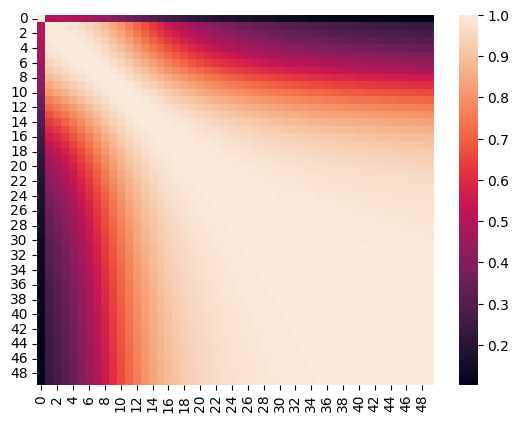

<Axes: >

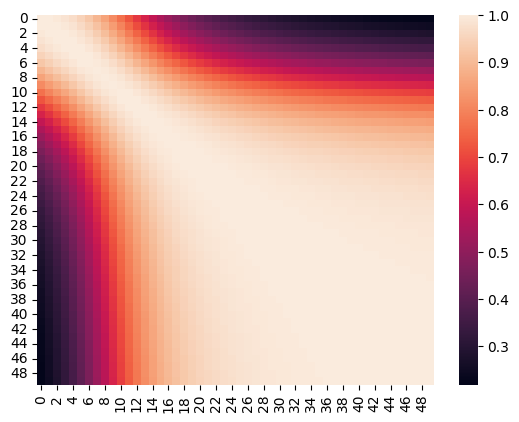

In [32]:
data=get_data(4)
sns.heatmap(np.array([[np.abs( np.dot(data.ground_states[i], np.conjugate(data.ground_states[j])))**2 for j in range(1,100,2)] for i in range(1,100,2)]))
plt.show()
mat = np.array([[np.abs( np.dot(data.ground_states[i], np.conjugate(data.ground_states[j])))**2 for j in range(1,100,2)] for i in range(1,100,2)])
sns.heatmap(mat)